In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from nltk import sent_tokenize, word_tokenize
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score,make_scorer
from time import time
import pickle


In [3]:
df=pd.read_csv("dataset.csv")

In [4]:
df.head()


,headline,label
0,cock suck before you piss around on my work,-1
1,you are gay or antisemmitian archangel white ...,-1
2,fuck your filthy mother in the ass dry,-1
3,get fuck ed up get fuck ed up got a drink t...,-1
4,stupid peace of shit stop deleting my stuff ...,-1


In [5]:
df['label'].unique()

array([-1,  0])

In [6]:
def perform_data_manipulation():
    df=pd.read_csv("dataset.csv")
    for index in df.index:
        if df.loc[index,"label"]==-1:
            df.loc[index,"label"] = 1
    return df
    

In [7]:
df=perform_data_manipulation()

In [8]:
df.head()

,headline,label
0,cock suck before you piss around on my work,1
1,you are gay or antisemmitian archangel white ...,1
2,fuck your filthy mother in the ass dry,1
3,get fuck ed up get fuck ed up got a drink t...,1
4,stupid peace of shit stop deleting my stuff ...,1


In [9]:
df["label"].unique()

array([1, 0])

In [10]:
def performdatadistribution(df):
    total=df.shape[0]
    num_non_toxic = df[df['label']==0].shape[0]
    slices = [num_non_toxic/total, (total-num_non_toxic)/total]
    labeling = ['Non-toxic','Toxic']
    explode = [0.2,0]
    plt.pie(slices,explode=explode,shadow=True,autopct="%1.1f%%",labels=labeling,wedgeprops={'edgecolor':'black'})
    plt.title('Number of Toxic Vs Non-Toxic Test Sample')
    plt.tight_layout()
    plt.show()



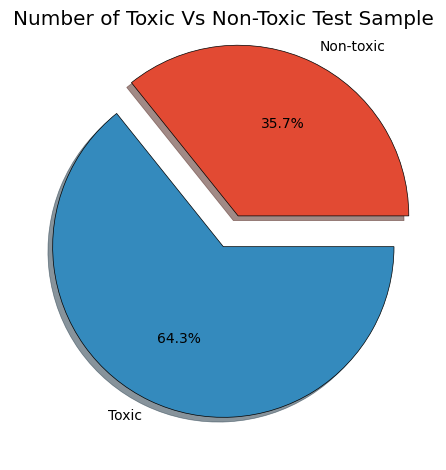

In [11]:
performdatadistribution(df)

In [12]:
def remove_pattern(input_txt,pattern):
    if (type(input_txt)==str):
        r= re.findall(pattern,input_txt)
        for i in r:
            input_txt=re.sub(i,'',input_txt)
        return input_txt
    else:
        return ""


In [13]:
df.head(1)

,headline,label
0,cock suck before you piss around on my work,1


In [14]:
def dataSetCleaning(df):
    
    df['length_headline']=df['headline'].str.len()
    combined_df = pd.concat([df, df], ignore_index=True)
    combined_df['tidy_tweet'] = combined_df['headline'].astype(str)
    
    
    combined_df['tidy_tweet']=np.vectorize(remove_pattern)(combined_df['headline'], r"@[\w]*")
    combined_df['tidy_tweet']= combined_df['tidy_tweet'].str.replace("[^a-zA-z#]"," ",regex=True)
    combined_df['tidy_tweet'] = combined_df['tidy_tweet'].apply(lambda x : ' '.join([w for w in x.split() if len(w)>3]))
    combined_df['length_tidy_tweet']=combined_df['tidy_tweet'].str.len()
    
    tokenized_tweet = combined_df['tidy_tweet'].apply(lambda x : x.split())
    nltk.download('wordnet')

    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokenized_tweet= tokenized_tweet.apply(lambda x: [lemmatizer.lemmatize(i) for i in x ] )
    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] =' '.join(tokenized_tweet[i])
    combined_df['tidy_tweet'] = tokenized_tweet
    
    return combined_df,df

    

In [15]:
combined_df,df=dataSetCleaning(df)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Pranavi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
combined_df.head()

,headline,label,length_headline,tidy_tweet,length_tidy_tweet
0,cock suck before you piss around on my work,1,44,cock suck before piss around work,33
1,you are gay or antisemmitian archangel white ...,1,624,antisemmitian archangel white tiger meow greet...,400
2,fuck your filthy mother in the ass dry,1,39,fuck your filthy mother,23
3,get fuck ed up get fuck ed up got a drink t...,1,121,fuck fuck drink that cant down fuck fuck fuck ...,51
4,stupid peace of shit stop deleting my stuff ...,1,93,stupid peace shit stop deleting stuff hole fal...,57


Dataset Splitting

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
def performdatasplit(x,y ,combined_df, df):
    X_train,X_test,y_train, y_test = train_test_split(combined_df['tidy_tweet'],combined_df['label'],test_size=x,random_state=y)
    print(f"Number of rows in the total dataset: {combined_df.shape[0]}")
    print(f"Number of rows in the total dataset: {X_train.shape[0]}")
    print(f"Number of rows in the total dataset: {X_test.shape[0]}")

    files=open("stopwords.txt" , "r")
    content=files.read()
    content_list = content.split("\n")
    files.close()
    Tfidvector = TfidfVectorizer(stop_words=content_list, lowercase=True)
    training_data = Tfidvector.fit_transform(X_train.values.astype('U'))
    testing_data = Tfidvector.transform(X_test.values.astype('U'))
    filename = 'TfidVectorizer.pkl'
    pickle.dump(Tfidvector.vocabulary_,open("TfidVectorizer.pkl", 'wb'))
    return X_train, X_test, y_train, y_test, testing_data, filename,training_data, content_list


In [19]:
X_train, X_test, y_train, y_test, testing_data, filename,training_data, content_list= performdatasplit(0.2,42,combined_df,df)

Number of rows in the total dataset: 36296
Number of rows in the total dataset: 29036
Number of rows in the total dataset: 7260


c:\Users\Pranavi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ninad'] not in stop_words.
  warnings.warn(


Apply ML ALgo

In [20]:
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from time import time
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


In [21]:
def pipeline(X_train, y_train, X_test, y_test):
    MODELS = [LinearSVC(), LogisticRegression(), MultinomialNB(), DecisionTreeClassifier(),
              AdaBoostClassifier(), BaggingClassifier(), SGDClassifier()]
    
    size = len(y_train)
    
    results = {}
    
    final_result = []
    
    for model in MODELS:
        results['Algorithm'] = model.__class__.__name__  
        start = time()
        print(f"Training Time : {model.__class__.__name__}")
        model.fit(X_train, y_train)
        end = time()
        
        filename = model.__class__.__name__+".pkl"
        pickle.dump(model, open(filename, "wb"))
        
        results['Training Time'] = end - start
        
        start = time()
        prediction_test = model.predict(X_test)
        prediction_train = model.predict(X_train)
        end = time()
        
        results['Prediction Time'] = end - start
        
        results['Accuracy : Test'] = accuracy_score(y_test, prediction_test)
        results['Accuracy : Train'] = accuracy_score(y_train, prediction_train)
        
        results['F1 Score : Test'] = f1_score(y_test, prediction_test)
        results['F1 Score : Train'] = f1_score(y_train, prediction_train)
        
        results['Precision : Test'] = precision_score(y_test, prediction_test)
        results['Precision : Train'] = precision_score(y_train, prediction_train)
        
        results['Recall : Test'] = recall_score(y_test, prediction_test)
        results['Recall : Train'] = recall_score(y_train, prediction_train)
        
        print(f"Training {model.__class__.__name__} finished in {results['Training Time']} sec")
        
        final_result.append(results.copy())
    return final_result

In [22]:
final_result = pipeline(training_data, y_train, testing_data, y_test)

Training Time : LinearSVC
Training LinearSVC finished in 0.19054913520812988 sec
Training Time : LogisticRegression
Training LogisticRegression finished in 1.0410585403442383 sec
Training Time : MultinomialNB
Training MultinomialNB finished in 0.014990568161010742 sec
Training Time : DecisionTreeClassifier
Training DecisionTreeClassifier finished in 8.597039699554443 sec
Training Time : AdaBoostClassifier


c:\Users\Pranavi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Training AdaBoostClassifier finished in 5.760853052139282 sec
Training Time : BaggingClassifier
Training BaggingClassifier finished in 73.54849791526794 sec
Training Time : SGDClassifier
Training SGDClassifier finished in 0.07869124412536621 sec


In [23]:
def performfinalresult(final_results):
    results = pd.DataFrame(final_results)
    results.reindex(columns = ['Algorithm', 'Accuracy : Test', 'Precision : Test', 'Recall : Test', 'F1 Score : Test', 'Prediction Time',
                          'Accuracy : Train', 'Precision : Train', 'Recall : Train', 'F1 Score : Train', 'Training Time'])
    results.sort_values(by = 'F1 Score : Test', inplace=True, ascending=False)
    
    return results

In [24]:

results = performfinalresult(final_result)
results.reset_index(drop = True)

,Algorithm,Training Time,Prediction Time,Accuracy : Test,Accuracy : Train,F1 Score : Test,F1 Score : Train,Precision : Test,Precision : Train,Recall : Test,Recall : Train
0,DecisionTreeClassifier,8.597040,0.041905,0.971488,0.996384,0.978130,0.997186,0.970034,0.995665,0.986363,0.998712
1,BaggingClassifier,73.548498,0.492269,0.967631,0.994455,0.975003,0.995682,0.973449,0.995014,0.976561,0.996350
2,LinearSVC,0.190549,0.006019,0.963636,0.987877,0.971855,0.990542,0.972477,0.991661,0.971234,0.989425
3,LogisticRegression,1.041059,0.002993,0.935675,0.960773,0.949984,0.969336,0.954996,0.972294,0.945025,0.966396
4,SGDClassifier,0.078691,0.002626,0.934435,0.957432,0.948751,0.966605,0.958868,0.973073,0.938845,0.960223
5,MultinomialNB,0.014991,0.011693,0.897934,0.926402,0.924534,0.944481,0.885486,0.915165,0.967185,0.975737
6,AdaBoostClassifier,5.760853,0.929003,0.838430,0.838993,0.861298,0.860460,0.967588,0.969074,0.776049,0.773740


In [25]:
results.describe().loc[['min', 'max'], :]

,Training Time,Prediction Time,Accuracy : Test,Accuracy : Train,F1 Score : Test,F1 Score : Train,Precision : Test,Precision : Train,Recall : Test,Recall : Train
min,0.014991,0.002626,0.838430,0.838993,0.861298,0.860460,0.885486,0.915165,0.776049,0.773740
max,73.548498,0.929003,0.971488,0.996384,0.978130,0.997186,0.973449,0.995665,0.986363,0.998712


Text(0.5, 1.0, 'Classification Summary of Algorithms')

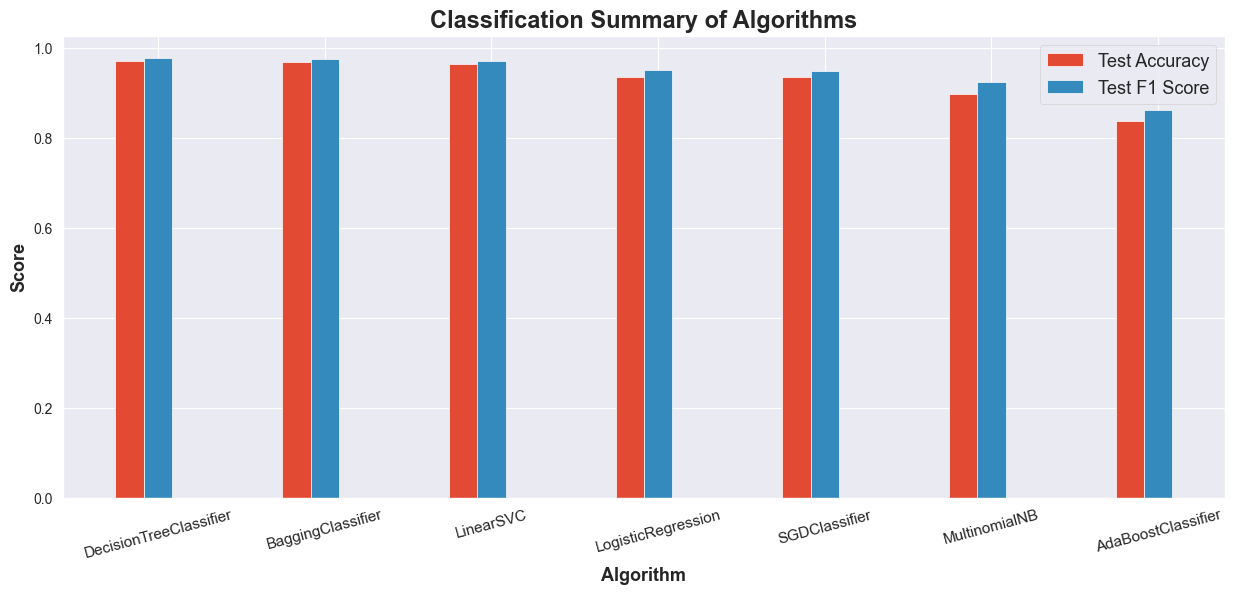

In [26]:
best_acc = results[results['Accuracy : Test'] == results['Accuracy : Test'].max()]
best_f1 = results[results['F1 Score : Test'] == results['F1 Score : Test'].max()]
best_precision = results[results['Precision : Test'] == results['Precision : Test'].max()]
best_recall = results[results['Recall : Test'] == results['Recall : Test'].max()]

sns.set_style('darkgrid')
plt.figure(figsize = (15, 6))

barWidth = 0.17
 
# set height of bar
bars1 = results['Accuracy : Test']
bars2 = results['F1 Score : Test']

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Make the plot
pal = sns.color_palette()
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Test Accuracy')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Test F1 Score')

# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Score', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)
 
# Create legend & Show graphic
plt.legend(fontsize = 13)

textstr = '\n'.join(['Best Accuracy: {:.3f} - {}'.format(best_acc['Accuracy : Test'].values[0], best_acc['Algorithm'].values[0]), 
                     'Best F1 Score: {:.3f} - {}'.format(best_f1['F1 Score : Test'].values[0], best_f1['Algorithm'].values[0])])
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

plt.title('Classification Summary of Algorithms', fontweight = 'bold', fontsize = 17)


Text(0.5, 1.0, 'Training and Prediction time of Algorithms')

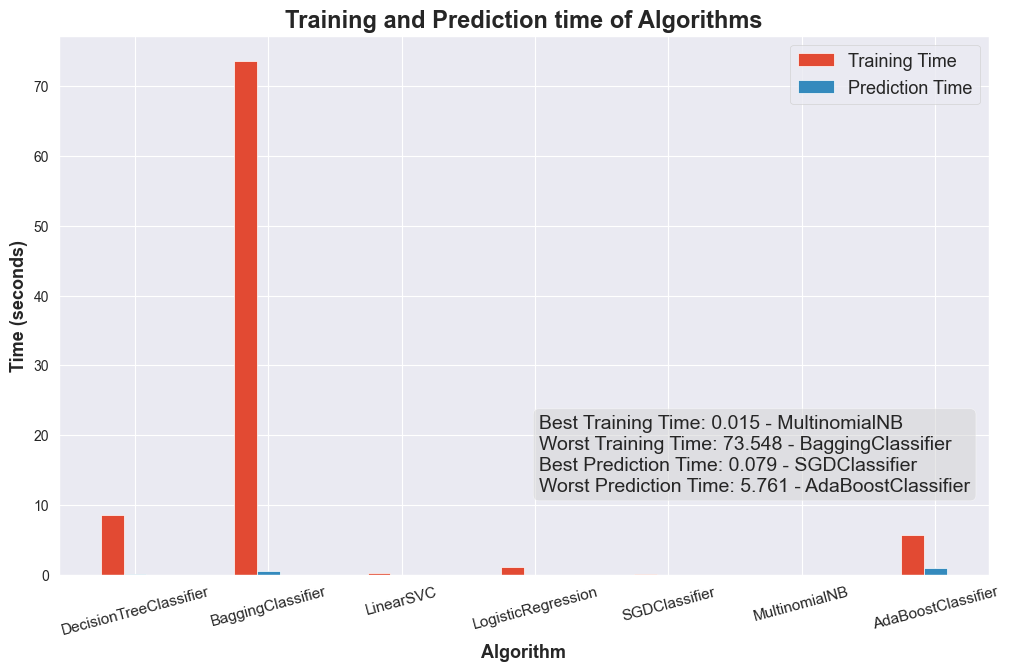

In [27]:
best_train_time = results[results['Training Time'] == results['Training Time'].min()]
worst_train_time = results[results['Training Time'] == results['Training Time'].max()]
best_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].min()]
worst_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].max()]

plt.figure(figsize = (12, 7))

barWidth = 0.17
 
# set height of bar
bars1 = results['Training Time']
bars2 = results['Prediction Time']
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Training Time')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Prediction Time')
 
# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Time (seconds)', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)


textstr = '\n'.join(('Best Training Time: {:.3f} - {}'.format(best_train_time['Training Time'].values[0], best_train_time['Algorithm'].values[0]), 
                     'Worst Training Time: {:.3f} - {}'.format(worst_train_time['Training Time'].values[0], worst_train_time['Algorithm'].values[0]),
                   'Best Prediction Time: {:.3f} - {}'.format(best_prediction_time['Training Time'].values[0], best_prediction_time['Algorithm'].values[0]), 
                    'Worst Prediction Time: {:.3f} - {}'.format(worst_prediction_time['Training Time'].values[0], worst_prediction_time['Algorithm'].values[0])))
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
plt.text(3.2, 12, textstr, fontsize=14,  bbox=props) 

# Create legend & Show graphic
plt.legend(fontsize = 13)
plt.title('Training and Prediction time of Algorithms', fontweight = 'bold', fontsize = 17)

In [28]:
df.head()

,headline,label,length_headline
0,cock suck before you piss around on my work,1,44
1,you are gay or antisemmitian archangel white ...,1,624
2,fuck your filthy mother in the ass dry,1,39
3,get fuck ed up get fuck ed up got a drink t...,1,121
4,stupid peace of shit stop deleting my stuff ...,1,93


In [29]:
data = ["I am sad"]

tfidf_vector = TfidfVectorizer(stop_words=content_list, lowercase=True, vocabulary=pickle.load(open("TfidVectorizer.pkl", "rb")))
preprocessed_data = tfidf_vector.fit_transform(data)

trained_model = pickle.load(open('LinearSVC.pkl', 'rb'))
print(trained_model.predict(preprocessed_data))

if(trained_model.predict(preprocessed_data)==1):
    print("bulling")
else:
    print("non-bulling")

[0]
non-bulling


c:\Users\Pranavi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ninad'] not in stop_words.
  warnings.warn(


In [30]:
from sklearn.model_selection import GridSearchCV
def tuining(clf, param_dict, X_train, y_train, X_test, y_test):
    scorer = make_scorer(f1_score)
    
    grid_obj = GridSearchCV(estimator=clf, param_grid=param_dict, scoring=scorer, cv=5)
    
    grid_fit = grid_obj.fit(X_train, y_train)
    
    best_clf = grid_fit.best_estimator_
    
    prediction = (clf.fit(X_train, y_train)).predict(X_test)
    
    best_prediction = best_clf.predict(X_test)
    
    print(clf.__class__.__name__)
    print(f"Best Parameter:  {grid_fit.best_params_}")
    
    print(f"Accuracy:  {accuracy_score(y_test, best_prediction)}")

    print(f"F1 Score :  {f1_score(y_test, best_prediction)}")
    
    print(f"Precision :  {precision_score(y_test, best_prediction)}")
    
    print(f"Recall:  {recall_score(y_test, best_prediction)}")


In [31]:
param_grid = {
    'C': [0.25, 0.5, 0.75, 1, 1.2]
}

clf_model = LinearSVC()

tuining(clf_model, param_grid, training_data, y_train, testing_data, y_test)

LinearSVC
Best Parameter:  {'C': 1.2}
Accuracy:  0.9641873278236914
F1 Score :  0.9722814498933902
Precision :  0.9729037764028163
Recall:  0.97165991902834


In [32]:

pickle.dump(clf_model, open("LinearSVCTuned.pkl", "wb"))